In [2]:
import scipy.io
import keras
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import pandas as pd
import random 
from keras.models import Sequential
from keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, UpSampling2D

from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline 



/Users/liginsolamen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
df=pd.read_msgpack('/Users/liginsolamen/MRE/MREData/MREdata_072118.msg')

In [4]:
Ur=np.stack(df.Ur.values,axis=3).transpose(3,0,1,2)
Ui=np.stack(df.Ui.values,axis=3).transpose(3,0,1,2)

X=np.sqrt(Ui**2+Ur**2)

Y=np.stack(df.RS.values,axis=2).transpose(2,0,1)
Y=Y.reshape(612,-1)
Y=Y/10000
print(X.shape)
print(Y.shape)

(612, 64, 64, 3)
(612, 4096)


In [7]:
train_X,test_X,train_Y,test_Y=train_test_split(X,Y,test_size=0.3)
train_X,valid_X,train_Y,valid_Y=train_test_split(train_X,train_Y,test_size=0.3)

print(X.shape) #612,64,64,3
print(Y.shape) #612,4096
print(train_X.shape) #(299, 64, 64, 3)
print(valid_X.shape) #(129, 64, 64, 3)
print(test_Y.shape) #(184, 4096)



(612, 64, 64, 3)
(612, 4096)
(299, 64, 64, 3)
(129, 64, 64, 3)
(184, 4096)


In [8]:
#Autoencoder

model=Sequential()

#Convolution
model.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu',
                 input_shape=(X.shape[1],X.shape[2],X.shape[3])))
model.add(Conv2D(50, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3),padding="same",
                 activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3),padding="same",
                 activation='relu'))

#Deconvolution
# model.add(Conv2D(32, kernel_size=(3, 3),padding='same',
#                  activation='relu'))

model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, kernel_size=(3, 3),padding='same',
                 activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, kernel_size=(3, 3),padding='same',
                 activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1, kernel_size=(3, 3),padding='same',
                 activation='relu'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 50)        28850     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 32)          14432     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 32)        9248      
__________

In [9]:
model.compile(loss='mean_squared_error',
              optimizer='adam')

train_Y=train_Y.reshape((train_Y.shape[0],64,64,1))
valid_Y=valid_Y.reshape((valid_Y.shape[0],64,64,1))


history=model.fit(train_X, train_Y,
          epochs=100,
          batch_size=1,
          validation_data=(valid_X, valid_Y))

Train on 299 samples, validate on 129 samples
Epoch 1/100
299/299 [==============================] - 11s 38ms/step - loss: 0.0257 - val_loss: 0.0256
Epoch 2/100
299/299 [==============================] - 10s 35ms/step - loss: 0.0198 - val_loss: 0.0158
Epoch 3/100
299/299 [==============================] - 9s 30ms/step - loss: 0.0173 - val_loss: 0.0139
Epoch 4/100
299/299 [==============================] - 9s 29ms/step - loss: 0.0133 - val_loss: 0.0120
Epoch 5/100
299/299 [==============================] - 9s 30ms/step - loss: 0.0106 - val_loss: 0.0094
Epoch 6/100
299/299 [==============================] - 9s 29ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 7/100
299/299 [==============================] - 9s 29ms/step - loss: 0.0072 - val_los

In [10]:
y_predict=model.predict(test_X)
test_Y=test_Y.reshape(test_Y.shape[0],64,64)
print(y_predict.shape)
y_predit2=y_predict.reshape(y_predict.shape[0],64,64)
print(y_predit2.shape)

(184, 64, 64, 1)
(184, 64, 64)


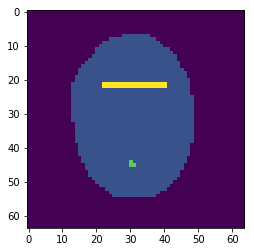

In [44]:
plt.imshow(test_Y[8])

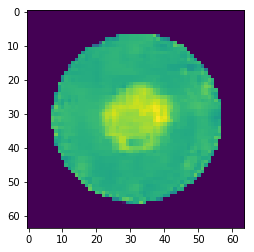

In [42]:
plt.imshow(y_predit2[6])

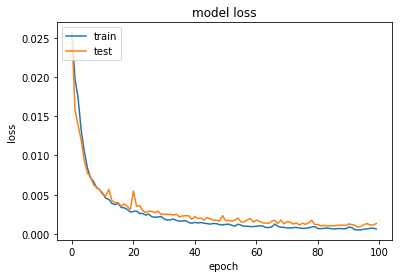

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
#Test with Contrast Detail Phantom
df_test=pd.read_msgpack('/Users/liginsolamen/MRE/MREData/Test_CDPhantom/Test_CDPhantom.msg')

Ur_test=np.stack(df_test.Ur.values,axis=3).transpose(3,0,1,2)
Ui_test=np.stack(df_test.Ui.values,axis=3).transpose(3,0,1,2)

X_testCD=np.sqrt(Ur_test**2+Ui_test**2)

Y_testCD=np.stack(df_test.RS.values,axis=2).transpose(2,0,1)
print(Y_testCD.shape)

(43, 64, 64)


In [24]:
#Y_testCD=Y_testCD.reshape(43,-1)
Y_testCD=Y_testCD/10000
print(X_testCD.shape)
print(Y_testCD.shape)

y_predict_CD=model.predict(X_testCD)
print(y_predict_CD.shape)

y_predict_CD=y_predict_CD.reshape(y_predict_CD.shape[0],64,64)
print(y_predict_CD.shape)


(43, 64, 64, 3)
(43, 64, 64)
(43, 64, 64, 1)
(43, 64, 64)


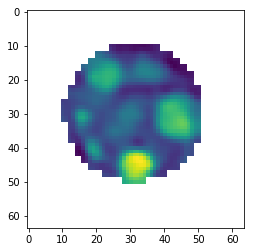

In [31]:
plt.imshow(Y_testCD[13])

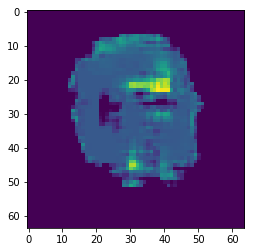

In [33]:
plt.imshow(y_predict_CD[13])